# Fictitious Degradation Dataset
For each experiment and for each loading condition there are different degradation paths that have some common
characteristics which we should discover.


In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive


from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
import tensorflow.keras as keras


config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

In [ ]:
from utils import get_indices, data_from_experiment, get_graph_data, get_graph_data_multiple_experiments, get_multi_batch

In [ ]:
## imports that are related to the fictitious dataset:

from datasets.fictitious_dataset import lhs_sample,transform_exp_data_to_random_signal_params,add_disturbances_in_signal,get_dat, make_experiments_3conditions

In [ ]:
latent = make_experiments_3conditions(nexp_per_case=10)
help(make_experiments_3conditions)

In [ ]:
pplot.plot(latent[0]['latent_values'])
pplot.plot(latent[2]['latent_values'])


In [ ]:
from datasets.fictitious_dataset import get_signal_for_segments

In [2]:
ss = get_signal_for_segments(latent[0]['latent_values'], speed = 150, rr=10)
pplot.plot(ss[-10,0:200])
pplot.plot(ss[10,0:200])


NameError: name 'get_signal_for_segments' is not defined

In [14]:
# for k in latent:
#     print(k)
#     pplot.plot(k['latent_values'])

In [15]:
latent = make_experiments_3conditions(nexp_per_case=10)


all_exp_dat = []
rr = 10
def reshape_ttf(v):
    if v.shape[0]%rr == 0:
        return np.mean(v.reshape([-1,rr]),1)
    else:
        return np.mean(v[:-(v.shape[0]%rr)].reshape([-1,rr]),1)
        
for d in latent:
    l = d['latent_values']
    ttf =d['ttf']
    
    y = reshape_ttf(ttf)
    case = d['case']
    speed_dict = {0:20, 1:25, 2:30}; # This is to superimpose a salient, yet irrelevant feature in the time-series.
                                     # Internally the network is expected to exploit this feature 
    if y.shape[0] == 0:
        break
    X = get_signal_for_segments(l, speed= speed_dict[case])
    eid = d['exp_index']

    exp_data = {
        "X" : X ,
        "eid" : (np.ones([X.shape[0],1]) * eid).astype(int),
        "y" : y,
        "case" : np.ones([X.shape[0],1]) * case
    }

    all_exp_dat.append(exp_data)

    

In [16]:
from datasets.fictitious_dataset import FictitiousDataset


In [17]:
fic=  FictitiousDataset(n_exp_per_case=5,pct_val_set=0.12,)


Created random data for fictitious experiment.
training experiments: 12 , testing 3


In [18]:
fic.X.shape,fic.y.shape, fic.cases.shape

((3196, 1000, 1), (3196, 1), (3196, 1))

In [21]:
def get_multi_batch_fictitious(*args, **kwargs):
    new_args = (args[0], fic)
    return get_multi_batch(*new_args, **kwargs)

def get_multi_batch_bootstrap_fictitious(*args,**kwargs):
    new_args = (args[0], fic)
    kwargs.update({"full_past_params" : {"min_idx_last_node" : 100 }})
    return get_multi_batch(*new_args,**kwargs)

In [1]:
v = get_multi_batch_bootstrap_fictitious(4,fic, nseq_range = 648651568, nnodes = 20, min_spacing = 5)

NameError: name 'get_multi_batch_bootstrap_fictitious' is not defined

In [ ]:
pplot.plot(np.hstack(v[0][0].node_times).T)

In [14]:
d = get_multi_batch(4,fic, nseq_range=100, nnodes = 5, min_spacing=2)

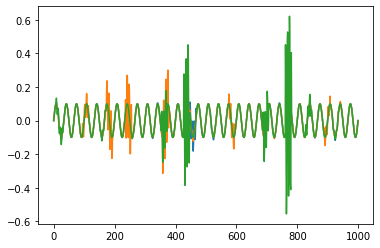

In [15]:
pplot.plot(exp_data['X'][0,:])
pplot.plot(exp_data['X'][10,:])
pplot.plot(exp_data['X'][100,:])


## Mini - graphnets
* **Edge**: Object keeping edge data - in this example dt and a latent output from the sender node.
* **Node**: Object keeping node data - in this example a latent variable (some function of observation and edge output).
* **Graph**: An object keeping edges/nodes corresponding to sequences of observations (and predictions?)
* **GraphNet**: An object defining how the computation happens on a graph object. It is a sequence of transformations and aggregations performed on edge and node states.

The information flowing through the graph may be better implemented in a sequential MC way. The nodes output samples or distributions, that are propagated by the edge to the time-instant corresponding to the receiver node. The edge aggregation function can be the application of Bayes rule in some way. 

## Utilities to make construction easier

## Classes for `Node` and `Edge` and `Graph`
These are classes encapsulating the attributes corresponding objects. Their behavior and the functions mutating them are implemented in a separate class (`GraphNet`) so that the graphNet can be evaluated with arbitrary graphs.

In [16]:
from minigraphnets import *

In [17]:
from graphnet_utils import GraphNetFunctionFactory
gn_tot = GraphNetFunctionFactory(channels_in =  1, 
                                 n_conv_blocks=2, 
                                 nfilts=32, 
                                 nfilts2=64,
                                 network_size_global = 100)

In [18]:
#gn_tot.load("/tmp/GraphNet_Fictitious")

In [19]:
gn_tot.make_graphnet_comp_blocks(fic.X[0].shape[0])



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



## The basic idea:
[alt-text](temporal_bayesian_graphnet.png)
Assuming this is markovian and I can capture something about the markov state with $z_i$, perhaps the second order links are not needed. Some more insight from what people in RL are using is needed to resolve this. 


### In more detail
* The input data, namely the raw time-series inputs and the difference in times for the observations,  are first transformed. The time-differences are simply projected to a 15 dimensional scalar and the time-series input is transformed using a convolutional neural network with global pooling to a 15 dimensional vector. 

* A second graph-net, that contains the causal links between the nodes of the graph, is then used to process the embedded quantities.
* The final inferred state is used to define the parameters of a `DistributionLambda` layer that is finally used to compute the final output. The final output is the time to failure for the final observation.

### Extensions
With adversarial learning the GraphNet should be able to infer prediction dependent and prediction independent states. This complicates implemetation (adversarial graph-nets would be yet another novel thing).

In [20]:
train_data = get_graph_data_multiple_experiments([0,2,3],fic.X, eid_oh_ = fic.eid_oh, yrem_norm_ = fic.yrem_norm ,
                                   nsamples_per_experiment = 50, nnodes = 10, min_spacing = 3, nseq_range=100)
gg_ = train_data[0][0]
predictions = train_data[0][1]

In [21]:
if False:
    gg_.edges[-1].edge_tensor.flatten().shape, predictions
    #gg_.edges[1].edge_tensor-gg_.edges[0].edge_tensor
    pplot.plot(gg_.edges[0].edge_tensor.flatten(),predictions.flatten(),'.')

## A cleaner training loop (with some standard training tricks)

In [22]:
from utils_train import EarlyStopping, LRScheduler, LossLogger
learning_rate = 0.001;
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_log = LossLogger()
early_stop = EarlyStopping(150,loss_log.loss_history['val_loss'])
lr_scheduler = LRScheduler(opt, epoch_decay = 40, decay_rate = 0.99)

ValueError: too many values to unpack (expected 5)

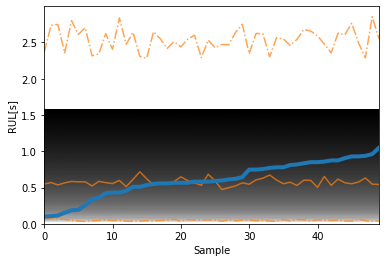

In [23]:
def eval_quantile(distr ,q, nsamples = 500):
    return np.quantile(distr.sample(nsamples),q,0)

def eval_graphnets(graph_in, iterations = 5):
    return gn_tot.eval_graphnets(graph_in.copy(), iterations = 5)

def plot_experiment_fit(graph_and_result_tuple, iterations =  5,
                        max_time = None,
                        colorscale_fn = lambda x : x, **kwargs):
    """
    returns v[:,ids_sort], q1,q2,qm, distribution, nll
    """
    #ind_exp = 0;
    y = graph_and_result_tuple[1]
    
    if max_time is None:
        max_time = np.max(y)*1.5
    
    t_probs= np.linspace(0,max_time,102)
    distribution = eval_graphnets(graph_and_result_tuple[0])
    nll = np.mean(-distribution.log_prob(y))
    v = distribution.prob(t_probs).numpy().T
    q1=eval_quantile(distribution,0.1)
    qm=eval_quantile(distribution,0.5)
    q2=eval_quantile(distribution,0.9)
    
    ids_sort = np.argsort(y.flatten());
    ysort = y[ids_sort.flatten()]
    xxvals = np.array([i for i in range(ysort.shape[0])])
    [xx,yy] = np.meshgrid(xxvals,t_probs)
    pplot.pcolor(xx,yy,colorscale_fn(v[:,ids_sort]), **kwargs)
    pplot.plot(xxvals,q1[ids_sort],'C1-.',alpha = 0.7)
    pplot.plot(xxvals,q2[ids_sort],'C1-.',alpha = 0.7)
    pplot.plot(xxvals,qm[ids_sort],'C1-', alpha = 0.7)
    pplot.plot(xxvals,y[ids_sort.flatten()],'C0-', linewidth = 4)
    
    pplot.xlabel("Sample")
    pplot.ylabel("RUL[s]")
    return v[:,ids_sort], q1,q2,qm, distribution, nll
    
yy,q1,q2,d, nll  = plot_experiment_fit( train_data[0], colorscale_fn=lambda x : x ** 0.5,  cmap = "gray")
#pplot.plot(q1)



In [34]:
res = gn_tot.bootstrap_eval_graphnets(train_data[0][0],n_bootstrap_samples=5, n_nodes_keep=2,return_final_node=False)



In [29]:

#gn_tot.core.node_to_prob_function(tf.reduce_mean(res,0))


<tfp.distributions.Gamma 'sequential_distribution_lambda_Gamma' batch_shape=[50, 1] event_shape=[] dtype=float32>

In [35]:
#gn_tot.eval_graphnets(train_data[0][0]).sample(1)



  0%|          | 0/200 [00:00<?, ?it/s]

nnodes: 1, seq_range 2 epoch: 0
loss: 11.441, val_loss 11.441
burn-in:  setting lr to 0.00000


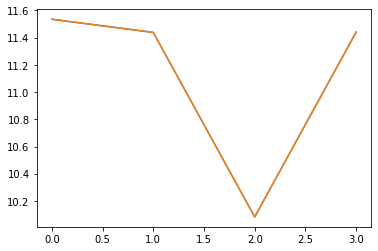

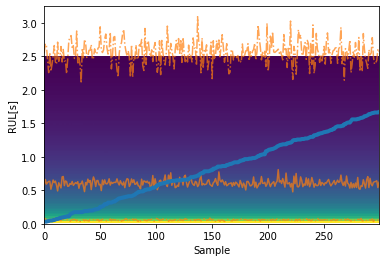



  0%|          | 1/200 [00:01<06:07,  1.85s/it]

nnodes: 2, seq_range 20 epoch: 1




  1%|          | 2/200 [00:03<05:40,  1.72s/it]

loss: 11.029, val_loss 11.029
burn-in:  setting lr to 0.00010
nnodes: 5, seq_range 150 epoch: 2




  2%|▏         | 3/200 [00:05<05:48,  1.77s/it]

loss: 6.066, val_loss 6.066
burn-in:  setting lr to 0.00020
nnodes: 10, seq_range 150 epoch: 3




  2%|▏         | 4/200 [00:08<06:51,  2.10s/it]

loss: 3.569, val_loss 3.569
burn-in:  setting lr to 0.00030
nnodes: 1, seq_range 2 epoch: 4




  2%|▎         | 5/200 [00:09<05:53,  1.81s/it]

loss: 10.765, val_loss 10.765
burn-in:  setting lr to 0.00040
nnodes: 2, seq_range 20 epoch: 5




  3%|▎         | 6/200 [00:10<05:27,  1.69s/it]

loss: 7.913, val_loss 7.913
burn-in:  setting lr to 0.00050
nnodes: 5, seq_range 150 epoch: 6




  4%|▎         | 7/200 [00:12<05:36,  1.74s/it]

loss: 0.576, val_loss 0.576
burn-in:  setting lr to 0.00060
nnodes: 10, seq_range 150 epoch: 7




  4%|▍         | 8/200 [00:15<06:36,  2.07s/it]

loss: -1.420, val_loss -1.420
burn-in:  setting lr to 0.00070
nnodes: 1, seq_range 2 epoch: 8




  4%|▍         | 9/200 [00:16<05:36,  1.76s/it]

loss: 10.028, val_loss 10.028
burn-in:  setting lr to 0.00080
nnodes: 2, seq_range 20 epoch: 9




  5%|▌         | 10/200 [00:17<05:14,  1.65s/it]

loss: 9.447, val_loss 9.447
burn-in:  setting lr to 0.00090
nnodes: 5, seq_range 150 epoch: 10
loss: 0.060, val_loss 0.060
burn-in:  setting lr to 0.00100


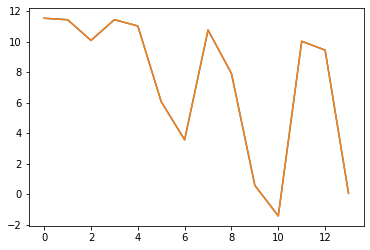

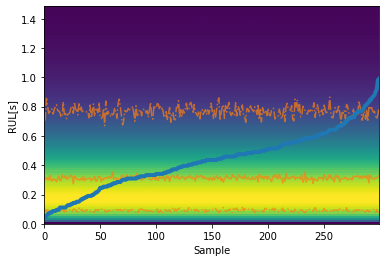



  6%|▌         | 11/200 [00:20<06:15,  1.99s/it]

nnodes: 10, seq_range 150 epoch: 11




  6%|▌         | 12/200 [00:23<06:56,  2.21s/it]

loss: -2.341, val_loss -2.341
nnodes: 1, seq_range 2 epoch: 12




  6%|▋         | 13/200 [00:24<05:46,  1.85s/it]

loss: 12.416, val_loss 12.416
nnodes: 2, seq_range 20 epoch: 13




  7%|▋         | 14/200 [00:25<05:17,  1.71s/it]

loss: 7.691, val_loss 7.691
nnodes: 5, seq_range 150 epoch: 14




  8%|▊         | 15/200 [00:27<05:27,  1.77s/it]

loss: 0.534, val_loss 0.534
nnodes: 10, seq_range 150 epoch: 15




  8%|▊         | 16/200 [00:30<06:25,  2.09s/it]

loss: -1.939, val_loss -1.939
nnodes: 1, seq_range 2 epoch: 16




  8%|▊         | 17/200 [00:31<05:26,  1.79s/it]

loss: 9.854, val_loss 9.854
nnodes: 2, seq_range 20 epoch: 17




  9%|▉         | 18/200 [00:32<05:03,  1.67s/it]

loss: 10.605, val_loss 10.605
nnodes: 5, seq_range 150 epoch: 18




 10%|▉         | 19/200 [00:34<05:14,  1.74s/it]

loss: 0.569, val_loss 0.569
nnodes: 10, seq_range 150 epoch: 19




 10%|█         | 20/200 [00:37<06:07,  2.04s/it]

loss: -1.679, val_loss -1.679
nnodes: 1, seq_range 2 epoch: 20
loss: 9.857, val_loss 9.857


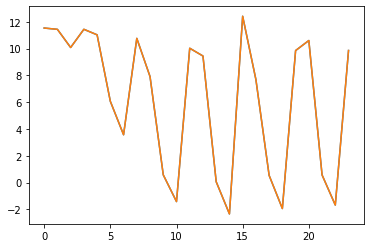

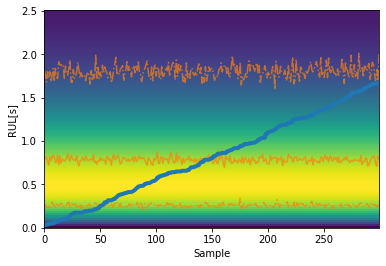



 10%|█         | 21/200 [00:39<05:52,  1.97s/it]

nnodes: 2, seq_range 20 epoch: 21




 11%|█         | 22/200 [00:40<05:18,  1.79s/it]

loss: 9.741, val_loss 9.741
nnodes: 5, seq_range 150 epoch: 22




 12%|█▏        | 23/200 [00:42<05:20,  1.81s/it]

loss: 1.389, val_loss 1.389
nnodes: 10, seq_range 150 epoch: 23




 12%|█▏        | 24/200 [00:45<06:08,  2.09s/it]

loss: -2.035, val_loss -2.035
nnodes: 1, seq_range 2 epoch: 24




 12%|█▎        | 25/200 [00:46<05:10,  1.77s/it]

loss: 11.493, val_loss 11.493
nnodes: 2, seq_range 20 epoch: 25




 13%|█▎        | 26/200 [00:47<04:52,  1.68s/it]

loss: 7.717, val_loss 7.717
nnodes: 5, seq_range 150 epoch: 26




 14%|█▎        | 27/200 [00:49<05:00,  1.74s/it]

loss: 2.485, val_loss 2.485
nnodes: 10, seq_range 150 epoch: 27




 14%|█▍        | 28/200 [00:52<05:52,  2.05s/it]

loss: -2.364, val_loss -2.364
nnodes: 1, seq_range 2 epoch: 28




 14%|█▍        | 29/200 [00:53<04:58,  1.74s/it]

loss: 9.384, val_loss 9.384
nnodes: 2, seq_range 20 epoch: 29




 15%|█▌        | 30/200 [00:54<04:39,  1.64s/it]

loss: 13.932, val_loss 13.932
nnodes: 5, seq_range 150 epoch: 30
loss: 2.093, val_loss 2.093


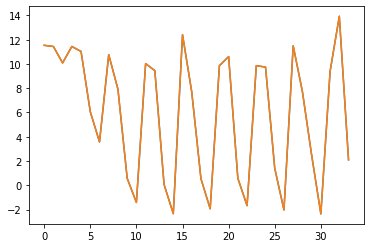

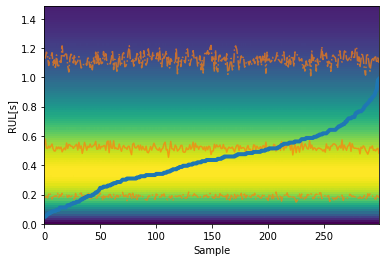



 16%|█▌        | 31/200 [00:57<05:30,  1.96s/it]

nnodes: 10, seq_range 150 epoch: 31




 16%|█▌        | 32/200 [01:00<06:07,  2.19s/it]

loss: -1.836, val_loss -1.836
nnodes: 1, seq_range 2 epoch: 32




 16%|█▋        | 33/200 [01:01<05:07,  1.84s/it]

loss: 9.378, val_loss 9.378
nnodes: 2, seq_range 20 epoch: 33




 17%|█▋        | 34/200 [01:02<04:45,  1.72s/it]

loss: 12.057, val_loss 12.057
nnodes: 5, seq_range 150 epoch: 34




 18%|█▊        | 35/200 [01:04<04:50,  1.76s/it]

loss: 1.638, val_loss 1.638
nnodes: 10, seq_range 150 epoch: 35




 18%|█▊        | 36/200 [01:07<05:49,  2.13s/it]

loss: -1.414, val_loss -1.414
nnodes: 1, seq_range 2 epoch: 36




 18%|█▊        | 37/200 [01:08<04:56,  1.82s/it]

loss: 8.849, val_loss 8.849
nnodes: 2, seq_range 20 epoch: 37




 19%|█▉        | 38/200 [01:10<04:40,  1.73s/it]

loss: 13.434, val_loss 13.434
nnodes: 5, seq_range 150 epoch: 38




 20%|█▉        | 39/200 [01:12<04:46,  1.78s/it]

loss: 0.484, val_loss 0.484
nnodes: 10, seq_range 150 epoch: 39




 20%|██        | 40/200 [01:15<05:40,  2.13s/it]

loss: -0.895, val_loss -0.895
nnodes: 1, seq_range 2 epoch: 40
loss: 8.621, val_loss 8.621
lr_decay: setting lr to 0.00099


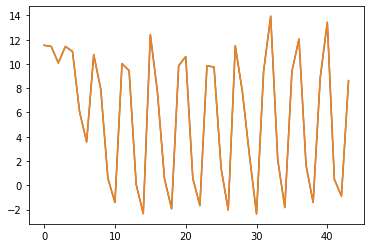

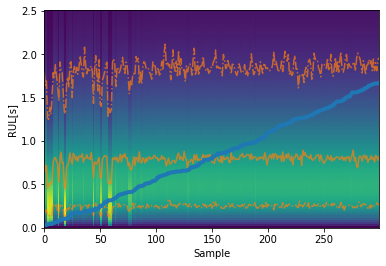



 20%|██        | 41/200 [01:16<05:23,  2.04s/it]

nnodes: 2, seq_range 20 epoch: 41




 21%|██        | 42/200 [01:18<04:51,  1.85s/it]

loss: 12.088, val_loss 12.088
lr_decay: setting lr to 0.00098
nnodes: 5, seq_range 150 epoch: 42




 22%|██▏       | 43/200 [01:20<04:51,  1.85s/it]

loss: 0.355, val_loss 0.355
lr_decay: setting lr to 0.00097
nnodes: 10, seq_range 150 epoch: 43




 22%|██▏       | 44/200 [01:22<05:34,  2.15s/it]

loss: -1.016, val_loss -1.016
lr_decay: setting lr to 0.00096
nnodes: 1, seq_range 2 epoch: 44




 22%|██▎       | 45/200 [01:23<04:40,  1.81s/it]

loss: 7.900, val_loss 7.900
lr_decay: setting lr to 0.00095
nnodes: 2, seq_range 20 epoch: 45




 23%|██▎       | 46/200 [01:25<04:19,  1.68s/it]

loss: 10.660, val_loss 10.660
lr_decay: setting lr to 0.00094
nnodes: 5, seq_range 150 epoch: 46




 24%|██▎       | 47/200 [01:27<04:27,  1.75s/it]

loss: 0.282, val_loss 0.282
lr_decay: setting lr to 0.00093
nnodes: 10, seq_range 150 epoch: 47




 24%|██▍       | 48/200 [01:29<05:11,  2.05s/it]

loss: -1.997, val_loss -1.997
lr_decay: setting lr to 0.00092
nnodes: 1, seq_range 2 epoch: 48




 24%|██▍       | 49/200 [01:31<04:23,  1.74s/it]

loss: 4.491, val_loss 4.491
lr_decay: setting lr to 0.00091
nnodes: 2, seq_range 20 epoch: 49




 25%|██▌       | 50/200 [01:32<04:06,  1.64s/it]

loss: 4.310, val_loss 4.310
lr_decay: setting lr to 0.00090
nnodes: 5, seq_range 150 epoch: 50
loss: -0.055, val_loss -0.055
lr_decay: setting lr to 0.00090


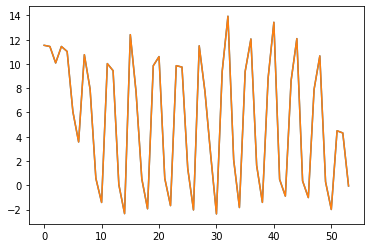

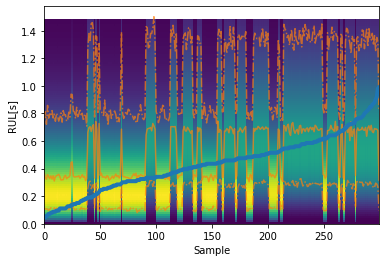



 26%|██▌       | 51/200 [01:35<04:53,  1.97s/it]

nnodes: 10, seq_range 150 epoch: 51




 26%|██▌       | 52/200 [01:37<05:25,  2.20s/it]

loss: -2.982, val_loss -2.982
lr_decay: setting lr to 0.00089
nnodes: 1, seq_range 2 epoch: 52




 26%|██▋       | 53/200 [01:38<04:30,  1.84s/it]

loss: 9.015, val_loss 9.015
lr_decay: setting lr to 0.00088
nnodes: 2, seq_range 20 epoch: 53




 27%|██▋       | 54/200 [01:40<04:07,  1.69s/it]

loss: 7.184, val_loss 7.184
lr_decay: setting lr to 0.00087
nnodes: 5, seq_range 150 epoch: 54




 28%|██▊       | 55/200 [01:42<04:13,  1.75s/it]

loss: -0.163, val_loss -0.163
lr_decay: setting lr to 0.00086
nnodes: 10, seq_range 150 epoch: 55




 28%|██▊       | 56/200 [01:44<04:59,  2.08s/it]

loss: -3.076, val_loss -3.076
lr_decay: setting lr to 0.00085
nnodes: 1, seq_range 2 epoch: 56




 28%|██▊       | 57/200 [01:46<04:11,  1.76s/it]

loss: 6.699, val_loss 6.699
lr_decay: setting lr to 0.00084
nnodes: 2, seq_range 20 epoch: 57




 29%|██▉       | 58/200 [01:47<03:54,  1.65s/it]

loss: 9.068, val_loss 9.068
lr_decay: setting lr to 0.00083
nnodes: 5, seq_range 150 epoch: 58




 30%|██▉       | 59/200 [01:49<04:02,  1.72s/it]

loss: -1.919, val_loss -1.919
lr_decay: setting lr to 0.00083
nnodes: 10, seq_range 150 epoch: 59




 30%|███       | 60/200 [01:52<04:47,  2.05s/it]

loss: -3.508, val_loss -3.508
lr_decay: setting lr to 0.00082
nnodes: 1, seq_range 2 epoch: 60
loss: 3.915, val_loss 3.915
lr_decay: setting lr to 0.00081


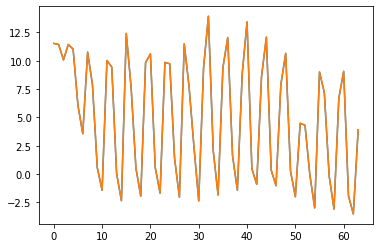

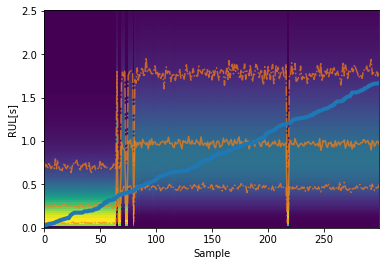



 30%|███       | 61/200 [01:53<04:32,  1.96s/it]

nnodes: 2, seq_range 20 epoch: 61




 31%|███       | 62/200 [01:55<04:05,  1.78s/it]

loss: 3.510, val_loss 3.510
lr_decay: setting lr to 0.00080
nnodes: 5, seq_range 150 epoch: 62




 32%|███▏      | 63/200 [01:57<04:08,  1.81s/it]

loss: -2.220, val_loss -2.220
lr_decay: setting lr to 0.00079
nnodes: 10, seq_range 150 epoch: 63




 32%|███▏      | 64/200 [01:59<04:48,  2.12s/it]

loss: -4.991, val_loss -4.991
lr_decay: setting lr to 0.00079
nnodes: 1, seq_range 2 epoch: 64




 32%|███▎      | 65/200 [02:00<04:02,  1.80s/it]

loss: 2.702, val_loss 2.702
lr_decay: setting lr to 0.00078
nnodes: 2, seq_range 20 epoch: 65




 33%|███▎      | 66/200 [02:02<03:43,  1.67s/it]

loss: 2.095, val_loss 2.095
lr_decay: setting lr to 0.00077
nnodes: 5, seq_range 150 epoch: 66




 34%|███▎      | 67/200 [02:04<03:49,  1.73s/it]

loss: -3.506, val_loss -3.506
lr_decay: setting lr to 0.00076
nnodes: 10, seq_range 150 epoch: 67




 34%|███▍      | 68/200 [02:06<04:28,  2.03s/it]

loss: -5.519, val_loss -5.519
lr_decay: setting lr to 0.00075
nnodes: 1, seq_range 2 epoch: 68




 34%|███▍      | 69/200 [02:07<03:46,  1.73s/it]

loss: 1.604, val_loss 1.604
lr_decay: setting lr to 0.00075
nnodes: 2, seq_range 20 epoch: 69




 35%|███▌      | 70/200 [02:09<03:30,  1.62s/it]

loss: 1.196, val_loss 1.196
lr_decay: setting lr to 0.00074
nnodes: 5, seq_range 150 epoch: 70
loss: -2.577, val_loss -2.577
lr_decay: setting lr to 0.00073


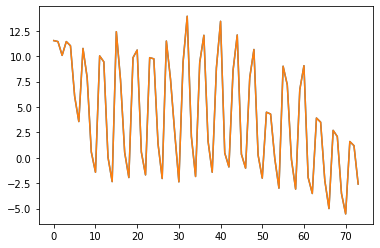

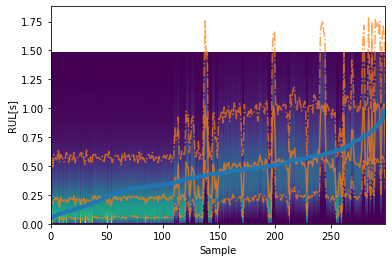



 36%|███▌      | 71/200 [02:12<04:12,  1.96s/it]

nnodes: 10, seq_range 150 epoch: 71




 36%|███▌      | 72/200 [02:14<04:40,  2.19s/it]

loss: -4.738, val_loss -4.738
lr_decay: setting lr to 0.00072
nnodes: 1, seq_range 2 epoch: 72




 36%|███▋      | 73/200 [02:15<03:53,  1.84s/it]

loss: 2.606, val_loss 2.606
lr_decay: setting lr to 0.00072
nnodes: 2, seq_range 20 epoch: 73




 37%|███▋      | 74/200 [02:17<03:34,  1.70s/it]

loss: 0.976, val_loss 0.976
lr_decay: setting lr to 0.00071
nnodes: 5, seq_range 150 epoch: 74




 38%|███▊      | 75/200 [02:19<03:39,  1.75s/it]

loss: -3.728, val_loss -3.728
lr_decay: setting lr to 0.00070
nnodes: 10, seq_range 150 epoch: 75




 38%|███▊      | 76/200 [02:21<04:18,  2.08s/it]

loss: -6.069, val_loss -6.069
lr_decay: setting lr to 0.00070
nnodes: 1, seq_range 2 epoch: 76




 38%|███▊      | 77/200 [02:22<03:37,  1.77s/it]

loss: 1.107, val_loss 1.107
lr_decay: setting lr to 0.00069
nnodes: 2, seq_range 20 epoch: 77




 39%|███▉      | 78/200 [02:24<03:21,  1.65s/it]

loss: 0.868, val_loss 0.868
lr_decay: setting lr to 0.00068
nnodes: 5, seq_range 150 epoch: 78




 40%|███▉      | 79/200 [02:26<03:28,  1.72s/it]

loss: -3.060, val_loss -3.060
lr_decay: setting lr to 0.00068
nnodes: 10, seq_range 150 epoch: 79




 40%|████      | 80/200 [02:29<04:08,  2.07s/it]

loss: -5.994, val_loss -5.994
lr_decay: setting lr to 0.00067
nnodes: 1, seq_range 2 epoch: 80
loss: 1.314, val_loss 1.314
lr_decay: setting lr to 0.00066


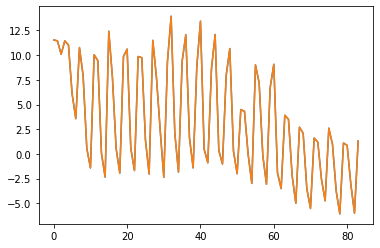

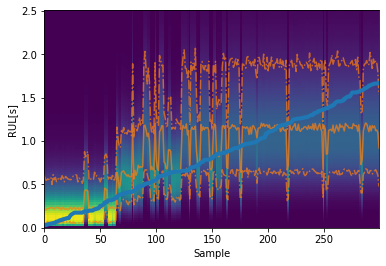



 40%|████      | 81/200 [02:30<03:54,  1.97s/it]

nnodes: 2, seq_range 20 epoch: 81




 41%|████      | 82/200 [02:32<03:31,  1.80s/it]

loss: 0.956, val_loss 0.956
lr_decay: setting lr to 0.00066
nnodes: 5, seq_range 150 epoch: 82




 42%|████▏     | 83/200 [02:34<03:38,  1.86s/it]

loss: -3.349, val_loss -3.349
lr_decay: setting lr to 0.00065
nnodes: 10, seq_range 150 epoch: 83




 42%|████▏     | 84/200 [02:37<04:12,  2.18s/it]

loss: -6.141, val_loss -6.141
lr_decay: setting lr to 0.00064
nnodes: 1, seq_range 2 epoch: 84




 42%|████▎     | 85/200 [02:38<03:32,  1.85s/it]

loss: 0.692, val_loss 0.692
lr_decay: setting lr to 0.00064
nnodes: 2, seq_range 20 epoch: 85




 43%|████▎     | 86/200 [02:39<03:21,  1.76s/it]

loss: 3.758, val_loss 3.758
lr_decay: setting lr to 0.00063
nnodes: 5, seq_range 150 epoch: 86




 44%|████▎     | 87/200 [02:41<03:23,  1.80s/it]

loss: -2.447, val_loss -2.447
lr_decay: setting lr to 0.00062
nnodes: 10, seq_range 150 epoch: 87




 44%|████▍     | 88/200 [02:44<03:54,  2.10s/it]

loss: -5.573, val_loss -5.573
lr_decay: setting lr to 0.00062
nnodes: 1, seq_range 2 epoch: 88




 44%|████▍     | 89/200 [02:45<03:16,  1.77s/it]

loss: 1.521, val_loss 1.521
lr_decay: setting lr to 0.00061
nnodes: 2, seq_range 20 epoch: 89




 45%|████▌     | 90/200 [02:46<03:02,  1.66s/it]

loss: 1.867, val_loss 1.867
lr_decay: setting lr to 0.00061
nnodes: 5, seq_range 150 epoch: 90
loss: -3.846, val_loss -3.846
lr_decay: setting lr to 0.00060


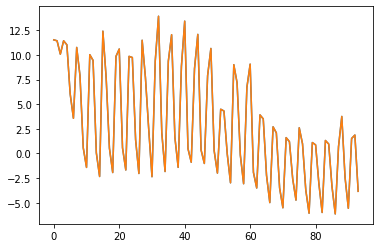

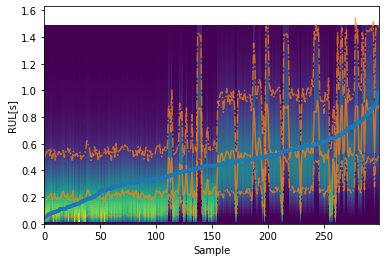



 46%|████▌     | 91/200 [02:49<03:39,  2.02s/it]

nnodes: 10, seq_range 150 epoch: 91




 46%|████▌     | 92/200 [02:52<04:06,  2.28s/it]

loss: -5.987, val_loss -5.987
lr_decay: setting lr to 0.00059
nnodes: 1, seq_range 2 epoch: 92




 46%|████▋     | 93/200 [02:53<03:24,  1.91s/it]

loss: 0.878, val_loss 0.878
lr_decay: setting lr to 0.00059
nnodes: 2, seq_range 20 epoch: 93




 47%|████▋     | 94/200 [02:55<03:07,  1.77s/it]

loss: 0.819, val_loss 0.819
lr_decay: setting lr to 0.00058
nnodes: 5, seq_range 150 epoch: 94




 48%|████▊     | 95/200 [02:57<03:14,  1.85s/it]

loss: -4.321, val_loss -4.321
lr_decay: setting lr to 0.00058
nnodes: 10, seq_range 150 epoch: 95




 48%|████▊     | 96/200 [03:00<03:46,  2.18s/it]

loss: -6.207, val_loss -6.207
lr_decay: setting lr to 0.00057
nnodes: 1, seq_range 2 epoch: 96




 48%|████▊     | 97/200 [03:01<03:10,  1.85s/it]

loss: 0.725, val_loss 0.725
lr_decay: setting lr to 0.00056
nnodes: 2, seq_range 20 epoch: 97




 49%|████▉     | 98/200 [03:02<02:56,  1.73s/it]

loss: 0.488, val_loss 0.488
lr_decay: setting lr to 0.00056
nnodes: 5, seq_range 150 epoch: 98




 50%|████▉     | 99/200 [03:04<02:59,  1.78s/it]

loss: -4.513, val_loss -4.513
lr_decay: setting lr to 0.00055
nnodes: 10, seq_range 150 epoch: 99




 50%|█████     | 100/200 [03:07<03:27,  2.08s/it]

loss: -6.649, val_loss -6.649
lr_decay: setting lr to 0.00055
nnodes: 1, seq_range 2 epoch: 100
loss: 0.647, val_loss 0.647
lr_decay: setting lr to 0.00054


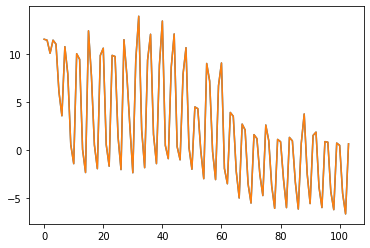

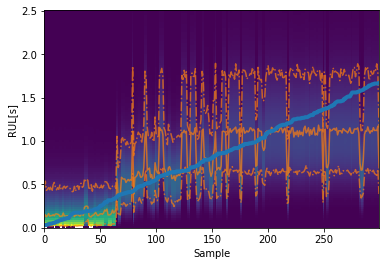



 50%|█████     | 101/200 [03:09<03:18,  2.00s/it]

nnodes: 2, seq_range 20 epoch: 101




 51%|█████     | 102/200 [03:10<02:58,  1.82s/it]

loss: 0.764, val_loss 0.764
lr_decay: setting lr to 0.00054
nnodes: 5, seq_range 150 epoch: 102




 52%|█████▏    | 103/200 [03:12<02:57,  1.83s/it]

loss: -5.028, val_loss -5.028
lr_decay: setting lr to 0.00053
nnodes: 10, seq_range 150 epoch: 103




 52%|█████▏    | 104/200 [03:15<03:24,  2.13s/it]

loss: -7.129, val_loss -7.129
lr_decay: setting lr to 0.00053
nnodes: 1, seq_range 2 epoch: 104




 52%|█████▎    | 105/200 [03:16<02:50,  1.79s/it]

loss: 0.222, val_loss 0.222
lr_decay: setting lr to 0.00052
nnodes: 2, seq_range 20 epoch: 105




 53%|█████▎    | 106/200 [03:17<02:36,  1.67s/it]

loss: 0.520, val_loss 0.520
lr_decay: setting lr to 0.00052
nnodes: 5, seq_range 150 epoch: 106




 54%|█████▎    | 107/200 [03:19<02:40,  1.73s/it]

loss: -4.965, val_loss -4.965
lr_decay: setting lr to 0.00051
nnodes: 10, seq_range 150 epoch: 107




 54%|█████▍    | 108/200 [03:22<03:07,  2.03s/it]

loss: -7.199, val_loss -7.199
lr_decay: setting lr to 0.00050
nnodes: 1, seq_range 2 epoch: 108




 55%|█████▍    | 109/200 [03:23<02:37,  1.74s/it]

loss: 0.476, val_loss 0.476
lr_decay: setting lr to 0.00050
nnodes: 2, seq_range 20 epoch: 109




 55%|█████▌    | 110/200 [03:24<02:26,  1.63s/it]

loss: 0.710, val_loss 0.710
lr_decay: setting lr to 0.00049
nnodes: 5, seq_range 150 epoch: 110
loss: -5.354, val_loss -5.354
lr_decay: setting lr to 0.00049


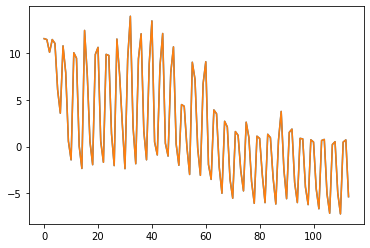

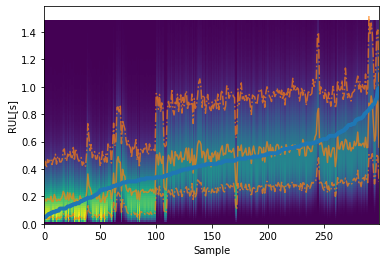



 56%|█████▌    | 111/200 [03:27<02:53,  1.95s/it]

nnodes: 10, seq_range 150 epoch: 111




 56%|█████▌    | 112/200 [03:30<03:12,  2.19s/it]

loss: -7.469, val_loss -7.469
lr_decay: setting lr to 0.00048
nnodes: 1, seq_range 2 epoch: 112




 56%|█████▋    | 113/200 [03:31<02:40,  1.84s/it]

loss: 0.383, val_loss 0.383
lr_decay: setting lr to 0.00048
nnodes: 2, seq_range 20 epoch: 113




 57%|█████▋    | 114/200 [03:32<02:26,  1.70s/it]

loss: 0.712, val_loss 0.712
lr_decay: setting lr to 0.00048
nnodes: 5, seq_range 150 epoch: 114




 57%|█████▊    | 115/200 [03:34<02:28,  1.75s/it]

loss: -5.372, val_loss -5.372
lr_decay: setting lr to 0.00047
nnodes: 10, seq_range 150 epoch: 115




 58%|█████▊    | 116/200 [03:37<02:54,  2.08s/it]

loss: -7.455, val_loss -7.455
lr_decay: setting lr to 0.00047
nnodes: 1, seq_range 2 epoch: 116




 58%|█████▊    | 117/200 [03:38<02:26,  1.77s/it]

loss: 0.448, val_loss 0.448
lr_decay: setting lr to 0.00046
nnodes: 2, seq_range 20 epoch: 117




 59%|█████▉    | 118/200 [03:39<02:16,  1.66s/it]

loss: 0.495, val_loss 0.495
lr_decay: setting lr to 0.00046
nnodes: 5, seq_range 150 epoch: 118




 60%|█████▉    | 119/200 [03:41<02:19,  1.73s/it]

loss: -5.910, val_loss -5.910
lr_decay: setting lr to 0.00045
nnodes: 10, seq_range 150 epoch: 119




 60%|██████    | 120/200 [03:44<02:45,  2.07s/it]

loss: -7.684, val_loss -7.684
lr_decay: setting lr to 0.00045
nnodes: 1, seq_range 2 epoch: 120
loss: 0.490, val_loss 0.490
lr_decay: setting lr to 0.00044


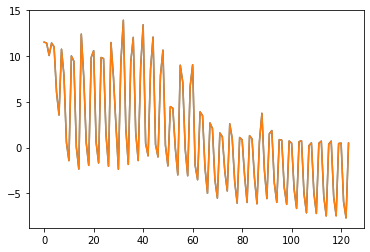

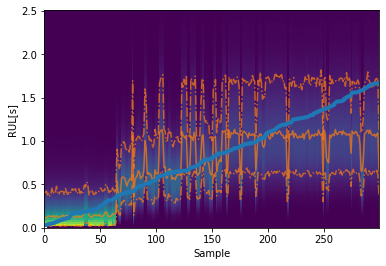



 60%|██████    | 121/200 [03:46<02:34,  1.96s/it]

nnodes: 2, seq_range 20 epoch: 121




 61%|██████    | 122/200 [03:47<02:19,  1.79s/it]

loss: -0.073, val_loss -0.073
lr_decay: setting lr to 0.00044
nnodes: 5, seq_range 150 epoch: 122




 62%|██████▏   | 123/200 [03:49<02:19,  1.81s/it]

loss: -6.248, val_loss -6.248
lr_decay: setting lr to 0.00043
nnodes: 10, seq_range 150 epoch: 123




 62%|██████▏   | 124/200 [03:52<02:41,  2.12s/it]

loss: -7.846, val_loss -7.846
lr_decay: setting lr to 0.00043
nnodes: 1, seq_range 2 epoch: 124




 62%|██████▎   | 125/200 [03:53<02:14,  1.79s/it]

loss: 0.201, val_loss 0.201
lr_decay: setting lr to 0.00043
nnodes: 2, seq_range 20 epoch: 125




 63%|██████▎   | 126/200 [03:54<02:03,  1.67s/it]

loss: -0.651, val_loss -0.651
lr_decay: setting lr to 0.00042
nnodes: 5, seq_range 150 epoch: 126




 64%|██████▎   | 127/200 [03:56<02:06,  1.73s/it]

loss: -6.398, val_loss -6.398
lr_decay: setting lr to 0.00042
nnodes: 10, seq_range 150 epoch: 127




 64%|██████▍   | 128/200 [03:59<02:27,  2.05s/it]

loss: -7.971, val_loss -7.971
lr_decay: setting lr to 0.00041
nnodes: 1, seq_range 2 epoch: 128




 64%|██████▍   | 129/200 [04:00<02:03,  1.74s/it]

loss: -0.088, val_loss -0.088
lr_decay: setting lr to 0.00041
nnodes: 2, seq_range 20 epoch: 129




 65%|██████▌   | 130/200 [04:01<01:54,  1.64s/it]

loss: -0.948, val_loss -0.948
lr_decay: setting lr to 0.00040
nnodes: 5, seq_range 150 epoch: 130
loss: -6.413, val_loss -6.413
lr_decay: setting lr to 0.00040


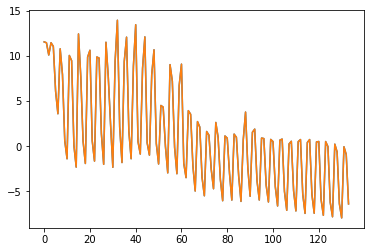

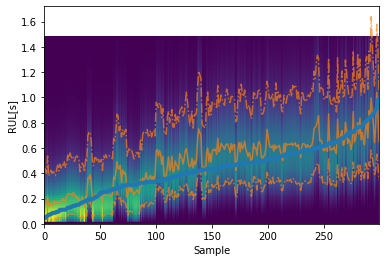



 66%|██████▌   | 131/200 [04:04<02:15,  1.96s/it]

nnodes: 10, seq_range 150 epoch: 131




 66%|██████▌   | 132/200 [04:07<02:29,  2.20s/it]

loss: -8.057, val_loss -8.057
lr_decay: setting lr to 0.00040
nnodes: 1, seq_range 2 epoch: 132




 66%|██████▋   | 133/200 [04:08<02:03,  1.84s/it]

loss: -0.317, val_loss -0.317
lr_decay: setting lr to 0.00039
nnodes: 2, seq_range 20 epoch: 133




 67%|██████▋   | 134/200 [04:09<01:52,  1.70s/it]

loss: -1.192, val_loss -1.192
lr_decay: setting lr to 0.00039
nnodes: 5, seq_range 150 epoch: 134




 68%|██████▊   | 135/200 [04:11<01:56,  1.79s/it]

loss: -6.572, val_loss -6.572
lr_decay: setting lr to 0.00038
nnodes: 10, seq_range 150 epoch: 135




 68%|██████▊   | 136/200 [04:14<02:13,  2.08s/it]

loss: -8.106, val_loss -8.106
lr_decay: setting lr to 0.00038
nnodes: 1, seq_range 2 epoch: 136




 68%|██████▊   | 137/200 [04:15<01:51,  1.76s/it]

loss: -0.499, val_loss -0.499
lr_decay: setting lr to 0.00038
nnodes: 2, seq_range 20 epoch: 137




 69%|██████▉   | 138/200 [04:16<01:42,  1.65s/it]

loss: -1.341, val_loss -1.341
lr_decay: setting lr to 0.00037
nnodes: 5, seq_range 150 epoch: 138




 70%|██████▉   | 139/200 [04:18<01:46,  1.74s/it]

loss: -6.933, val_loss -6.933
lr_decay: setting lr to 0.00037
nnodes: 10, seq_range 150 epoch: 139




 70%|███████   | 140/200 [04:21<02:08,  2.15s/it]

loss: -8.397, val_loss -8.397
lr_decay: setting lr to 0.00037
nnodes: 1, seq_range 2 epoch: 140
loss: -0.582, val_loss -0.582
lr_decay: setting lr to 0.00036


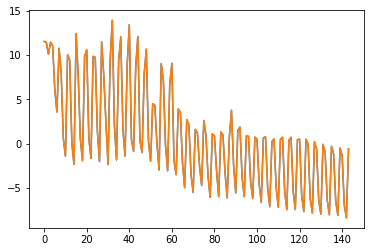

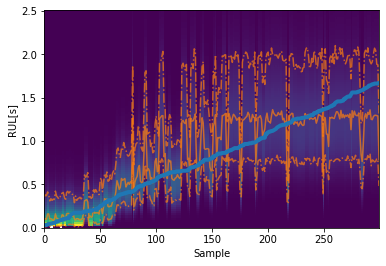



 70%|███████   | 141/200 [04:23<02:00,  2.03s/it]

nnodes: 2, seq_range 20 epoch: 141




 71%|███████   | 142/200 [04:24<01:46,  1.84s/it]

loss: -1.513, val_loss -1.513
lr_decay: setting lr to 0.00036
nnodes: 5, seq_range 150 epoch: 142




 72%|███████▏  | 143/200 [04:26<01:45,  1.85s/it]

loss: -7.168, val_loss -7.168
lr_decay: setting lr to 0.00036
nnodes: 10, seq_range 150 epoch: 143




 72%|███████▏  | 144/200 [04:29<02:05,  2.23s/it]

loss: -8.574, val_loss -8.574
lr_decay: setting lr to 0.00035
nnodes: 1, seq_range 2 epoch: 144




 72%|███████▎  | 145/200 [04:31<01:46,  1.94s/it]

loss: -0.540, val_loss -0.540
lr_decay: setting lr to 0.00035
nnodes: 2, seq_range 20 epoch: 145




 73%|███████▎  | 146/200 [04:32<01:38,  1.82s/it]

loss: -1.435, val_loss -1.435
lr_decay: setting lr to 0.00034
nnodes: 5, seq_range 150 epoch: 146




 74%|███████▎  | 147/200 [04:34<01:40,  1.90s/it]

loss: -7.067, val_loss -7.067
lr_decay: setting lr to 0.00034
nnodes: 10, seq_range 150 epoch: 147




 74%|███████▍  | 148/200 [04:37<01:53,  2.18s/it]

loss: -8.384, val_loss -8.384
lr_decay: setting lr to 0.00034
nnodes: 1, seq_range 2 epoch: 148




 74%|███████▍  | 149/200 [04:38<01:33,  1.83s/it]

loss: -0.097, val_loss -0.097
lr_decay: setting lr to 0.00033
nnodes: 2, seq_range 20 epoch: 149




 75%|███████▌  | 150/200 [04:40<01:25,  1.70s/it]

loss: -1.369, val_loss -1.369
lr_decay: setting lr to 0.00033
nnodes: 5, seq_range 150 epoch: 150
loss: -6.432, val_loss -6.432
lr_decay: setting lr to 0.00033


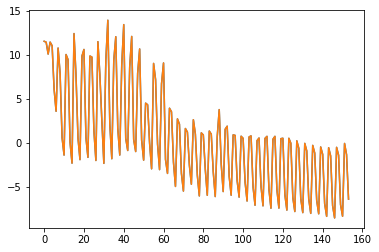

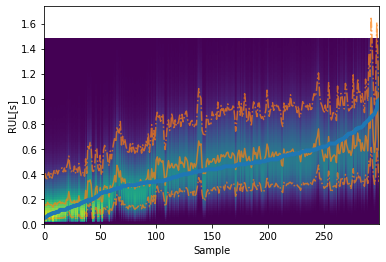



 76%|███████▌  | 151/200 [04:42<01:38,  2.01s/it]

nnodes: 10, seq_range 150 epoch: 151




 76%|███████▌  | 152/200 [04:45<01:50,  2.29s/it]

loss: -8.425, val_loss -8.425
lr_decay: setting lr to 0.00032
nnodes: 1, seq_range 2 epoch: 152




 76%|███████▋  | 153/200 [04:46<01:29,  1.90s/it]

loss: 0.622, val_loss 0.622
lr_decay: setting lr to 0.00032
nnodes: 2, seq_range 20 epoch: 153




 77%|███████▋  | 154/200 [04:48<01:21,  1.78s/it]

loss: -1.186, val_loss -1.186
lr_decay: setting lr to 0.00032
nnodes: 5, seq_range 150 epoch: 154




 78%|███████▊  | 155/200 [04:50<01:23,  1.86s/it]

loss: -6.578, val_loss -6.578
lr_decay: setting lr to 0.00031
nnodes: 10, seq_range 150 epoch: 155




 78%|███████▊  | 156/200 [04:53<01:35,  2.17s/it]

loss: -8.822, val_loss -8.822
lr_decay: setting lr to 0.00031
nnodes: 1, seq_range 2 epoch: 156




 78%|███████▊  | 157/200 [04:54<01:19,  1.86s/it]

loss: -0.826, val_loss -0.826
lr_decay: setting lr to 0.00031
nnodes: 2, seq_range 20 epoch: 157




 79%|███████▉  | 158/200 [04:55<01:12,  1.72s/it]

loss: -0.603, val_loss -0.603
lr_decay: setting lr to 0.00031
nnodes: 5, seq_range 150 epoch: 158




 80%|███████▉  | 159/200 [04:57<01:12,  1.77s/it]

loss: -6.676, val_loss -6.676
lr_decay: setting lr to 0.00030
nnodes: 10, seq_range 150 epoch: 159




 80%|████████  | 160/200 [05:00<01:23,  2.10s/it]

loss: -8.956, val_loss -8.956
lr_decay: setting lr to 0.00030
nnodes: 1, seq_range 2 epoch: 160
loss: -0.923, val_loss -0.923
lr_decay: setting lr to 0.00030


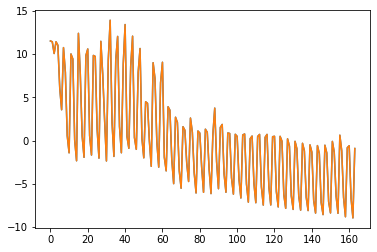

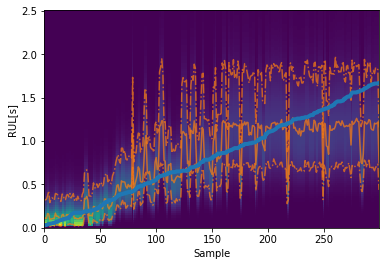



 80%|████████  | 161/200 [05:02<01:18,  2.01s/it]

nnodes: 2, seq_range 20 epoch: 161




 81%|████████  | 162/200 [05:03<01:09,  1.83s/it]

loss: -1.402, val_loss -1.402
lr_decay: setting lr to 0.00029
nnodes: 5, seq_range 150 epoch: 162




 82%|████████▏ | 163/200 [05:05<01:09,  1.87s/it]

loss: -7.449, val_loss -7.449
lr_decay: setting lr to 0.00029
nnodes: 10, seq_range 150 epoch: 163




 82%|████████▏ | 164/200 [05:08<01:20,  2.22s/it]

loss: -9.284, val_loss -9.284
lr_decay: setting lr to 0.00029
nnodes: 1, seq_range 2 epoch: 164




 82%|████████▎ | 165/200 [05:09<01:05,  1.88s/it]

loss: -1.054, val_loss -1.054
lr_decay: setting lr to 0.00028
nnodes: 2, seq_range 20 epoch: 165




 83%|████████▎ | 166/200 [05:11<00:58,  1.73s/it]

loss: -1.812, val_loss -1.812
lr_decay: setting lr to 0.00028
nnodes: 5, seq_range 150 epoch: 166




 84%|████████▎ | 167/200 [05:13<00:59,  1.79s/it]

loss: -7.565, val_loss -7.565
lr_decay: setting lr to 0.00028
nnodes: 10, seq_range 150 epoch: 167




 84%|████████▍ | 168/200 [05:15<01:06,  2.08s/it]

loss: -9.368, val_loss -9.368
lr_decay: setting lr to 0.00028
nnodes: 1, seq_range 2 epoch: 168




 84%|████████▍ | 169/200 [05:16<00:54,  1.77s/it]

loss: -1.121, val_loss -1.121
lr_decay: setting lr to 0.00027
nnodes: 2, seq_range 20 epoch: 169




 85%|████████▌ | 170/200 [05:18<00:49,  1.66s/it]

loss: -2.004, val_loss -2.004
lr_decay: setting lr to 0.00027
nnodes: 5, seq_range 150 epoch: 170
loss: -7.674, val_loss -7.674
lr_decay: setting lr to 0.00027


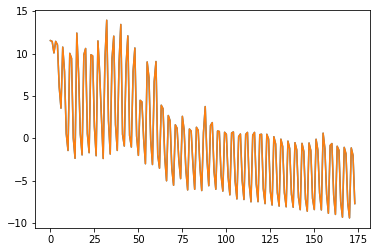

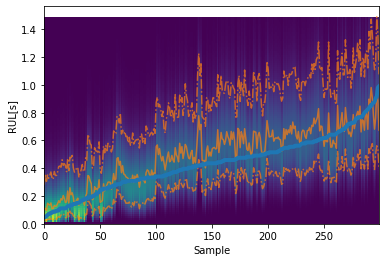



 86%|████████▌ | 171/200 [05:21<00:57,  1.98s/it]

nnodes: 10, seq_range 150 epoch: 171




 86%|████████▌ | 172/200 [05:23<01:02,  2.21s/it]

loss: -9.445, val_loss -9.445
lr_decay: setting lr to 0.00027
nnodes: 1, seq_range 2 epoch: 172




 86%|████████▋ | 173/200 [05:24<00:50,  1.85s/it]

loss: -1.174, val_loss -1.174
lr_decay: setting lr to 0.00026
nnodes: 2, seq_range 20 epoch: 173




 87%|████████▋ | 174/200 [05:26<00:46,  1.78s/it]

loss: -2.096, val_loss -2.096
lr_decay: setting lr to 0.00026
nnodes: 5, seq_range 150 epoch: 174




 88%|████████▊ | 175/200 [05:28<00:46,  1.88s/it]

loss: -7.746, val_loss -7.746
lr_decay: setting lr to 0.00026
nnodes: 10, seq_range 150 epoch: 175




 88%|████████▊ | 176/200 [05:31<00:53,  2.23s/it]

loss: -9.507, val_loss -9.507
lr_decay: setting lr to 0.00025
nnodes: 1, seq_range 2 epoch: 176




 88%|████████▊ | 177/200 [05:32<00:44,  1.94s/it]

loss: -1.239, val_loss -1.239
lr_decay: setting lr to 0.00025
nnodes: 2, seq_range 20 epoch: 177




 89%|████████▉ | 178/200 [05:34<00:40,  1.83s/it]

loss: -2.148, val_loss -2.148
lr_decay: setting lr to 0.00025
nnodes: 5, seq_range 150 epoch: 178




 90%|████████▉ | 179/200 [05:36<00:40,  1.91s/it]

loss: -7.790, val_loss -7.790
lr_decay: setting lr to 0.00025
nnodes: 10, seq_range 150 epoch: 179




 90%|█████████ | 180/200 [05:39<00:44,  2.24s/it]

loss: -9.558, val_loss -9.558
lr_decay: setting lr to 0.00024
nnodes: 1, seq_range 2 epoch: 180
loss: -1.282, val_loss -1.282
lr_decay: setting lr to 0.00024


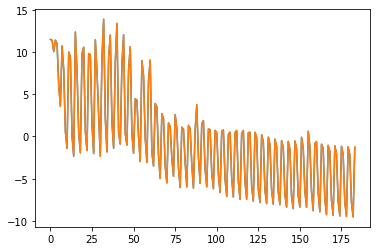

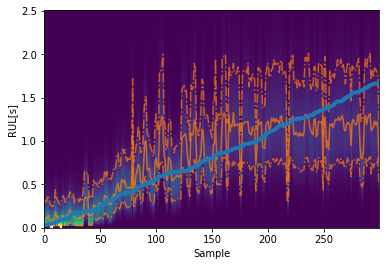



 90%|█████████ | 181/200 [05:41<00:40,  2.11s/it]

nnodes: 2, seq_range 20 epoch: 181




 91%|█████████ | 182/200 [05:42<00:34,  1.89s/it]

loss: -2.184, val_loss -2.184
lr_decay: setting lr to 0.00024
nnodes: 5, seq_range 150 epoch: 182




 92%|█████████▏| 183/200 [05:44<00:32,  1.90s/it]

loss: -7.841, val_loss -7.841
lr_decay: setting lr to 0.00024
nnodes: 10, seq_range 150 epoch: 183




 92%|█████████▏| 184/200 [05:47<00:35,  2.19s/it]

loss: -9.619, val_loss -9.619
lr_decay: setting lr to 0.00024
nnodes: 1, seq_range 2 epoch: 184




 92%|█████████▎| 185/200 [05:48<00:27,  1.84s/it]

loss: -1.332, val_loss -1.332
lr_decay: setting lr to 0.00023
nnodes: 2, seq_range 20 epoch: 185




 93%|█████████▎| 186/200 [05:49<00:24,  1.72s/it]

loss: -2.223, val_loss -2.223
lr_decay: setting lr to 0.00023
nnodes: 5, seq_range 150 epoch: 186




 94%|█████████▎| 187/200 [05:51<00:23,  1.77s/it]

loss: -7.891, val_loss -7.891
lr_decay: setting lr to 0.00023
nnodes: 10, seq_range 150 epoch: 187




 94%|█████████▍| 188/200 [05:54<00:24,  2.08s/it]

loss: -9.688, val_loss -9.688
lr_decay: setting lr to 0.00023
nnodes: 1, seq_range 2 epoch: 188




 94%|█████████▍| 189/200 [05:55<00:19,  1.77s/it]

loss: -1.387, val_loss -1.387
lr_decay: setting lr to 0.00022
nnodes: 2, seq_range 20 epoch: 189




 95%|█████████▌| 190/200 [05:57<00:16,  1.65s/it]

loss: -2.277, val_loss -2.277
lr_decay: setting lr to 0.00022
nnodes: 5, seq_range 150 epoch: 190
loss: -7.944, val_loss -7.944
lr_decay: setting lr to 0.00022


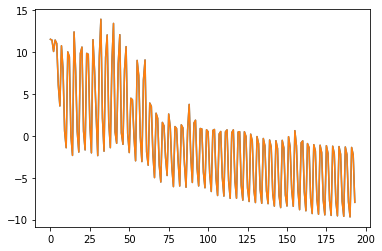

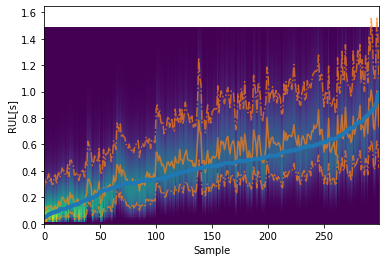



 96%|█████████▌| 191/200 [05:59<00:17,  1.98s/it]

nnodes: 10, seq_range 150 epoch: 191




 96%|█████████▌| 192/200 [06:02<00:18,  2.26s/it]

loss: -9.751, val_loss -9.751
lr_decay: setting lr to 0.00022
nnodes: 1, seq_range 2 epoch: 192




 96%|█████████▋| 193/200 [06:03<00:13,  1.89s/it]

loss: -1.427, val_loss -1.427
lr_decay: setting lr to 0.00021
nnodes: 2, seq_range 20 epoch: 193




 97%|█████████▋| 194/200 [06:05<00:10,  1.77s/it]

loss: -2.336, val_loss -2.336
lr_decay: setting lr to 0.00021
nnodes: 5, seq_range 150 epoch: 194




 98%|█████████▊| 195/200 [06:07<00:09,  1.82s/it]

loss: -8.002, val_loss -8.002
lr_decay: setting lr to 0.00021
nnodes: 10, seq_range 150 epoch: 195




 98%|█████████▊| 196/200 [06:10<00:08,  2.16s/it]

loss: -9.807, val_loss -9.807
lr_decay: setting lr to 0.00021
nnodes: 1, seq_range 2 epoch: 196




 98%|█████████▊| 197/200 [06:11<00:05,  1.82s/it]

loss: -1.457, val_loss -1.457
lr_decay: setting lr to 0.00021
nnodes: 2, seq_range 20 epoch: 197




 99%|█████████▉| 198/200 [06:12<00:03,  1.72s/it]

loss: -2.389, val_loss -2.389
lr_decay: setting lr to 0.00020
nnodes: 5, seq_range 150 epoch: 198




100%|█████████▉| 199/200 [06:14<00:01,  1.77s/it]

loss: -8.062, val_loss -8.062
lr_decay: setting lr to 0.00020
nnodes: 10, seq_range 150 epoch: 199




100%|██████████| 200/200 [06:17<00:00,  1.89s/it]

loss: -9.855, val_loss -9.855
lr_decay: setting lr to 0.00020


In [37]:
n_epochs = 200
nnodes_schedule = [1,2,5,10]
nseq_range_schedule = [2,20,150,150]
min_spacing_schedule = [1,5,5,5]
iterations_schedule = [5]
nbatch = 300
val_pct = 0.2 # percentage of sequence samples from the **seen ** experiments used as a validation set.
fixed_spacing_indices = False

eval_mode = "batched"
from tqdm import tqdm
for i in tqdm(range(n_epochs)):
    np.random.seed(42); 
    epoch = i
    
    # This makes sure that I always get different training and validation sets (there can still be some overlap but training should work ok)
    nnodes      = nnodes_schedule[i%len(nnodes_schedule)]
    nseq_range  = nseq_range_schedule[i%len(nseq_range_schedule)]
    min_spacing = min_spacing_schedule[i%len(min_spacing_schedule)]
    iterations = iterations_schedule[i%len(iterations_schedule)]
    
    if (nnodes * min_spacing) > nseq_range:
        min_spacing = 10
        nseq_range = nnodes * min_spacing+10
        
    print("nnodes: %i, seq_range %i epoch: %i"%(nnodes, nseq_range, i))
    curr_data = get_multi_batch_fictitious(nbatch, source_ds=True,nnodes=nnodes,
                                min_spacing = min_spacing,
                                nseq_range = nseq_range,
                                fixed_spacing_indices=fixed_spacing_indices);
    
    loss_epoch = 0;
    val_loss_epoch = 0;
    
    for single_minibatch in curr_data:
        with tf.GradientTape() as tape:
            graph_curr, y_curr = single_minibatch;
            #print(graph_curr)
            #def eval_graphnets_loss(graph_curr_, ycurr_,iterations):
            prob_out = gn_tot.eval_graphnets(graph_curr.copy(), iterations, eval_mode=eval_mode)
            loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T)
            #ycurr_t = y_curr[np.newaxis].T
            #ycurr_t = tf.Variable(ycurr_t)
            #loss_vals=  eval_graphnets_loss(graph_curr.copy(), ycurr_t, tf.constant(iterations))
            
            all_weights =gn_tot.weights() 
            
            
            train_loss = loss_vals[0:int(nbatch*(1-val_pct))];
            
            grads = tape.gradient(train_loss, all_weights)
            all_weights_filt = [all_weights[k] for k in range(len(grads)) if grads[k] is not None]
            grads_filt = [grads[k] for k in range(len(grads)) if grads[k] is not None]
            opt.apply_gradients(zip(grads_filt, all_weights_filt))
            loss_epoch += train_loss/len(y_curr)
        
        val_loss_epoch += tf.reduce_mean(loss_vals[int(-nbatch*(val_pct)):])
        
    loss_log.append_loss(np.sum(loss_epoch.numpy()))
    loss_log.append_val_loss(np.sum(val_loss_epoch.numpy()))
    loss_log.print()
    lr_scheduler.on_epoch_end(epoch)
    if early_stop.on_epoch_end(epoch):
        break
        
    if epoch%10 == 0:
        pplot.plot(loss_log.loss_history['loss'])
        pplot.plot(loss_log.loss_history['val_loss'])
        pplot.show()
        plot_experiment_fit(curr_data[0])
        pplot.show()

In [38]:
#plot_experiment_fit()
#curr_data[2]

In [39]:
#graph_indep.graph_eval(graph_data_.copy())
#graph_data_.nodes[0].node_attr_tensor.shape

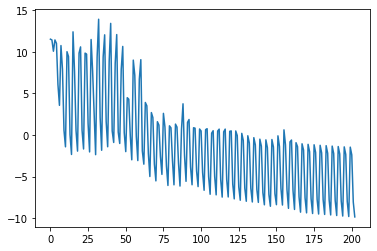

In [40]:
pplot.plot(loss_log.loss_history['val_loss'])
pplot.show()

In [41]:
help(get_graph_data_multiple_experiments)


    

Help on function get_graph_data_multiple_experiments in module utils:

get_graph_data_multiple_experiments(experiments, X_=None, eid_oh_=None, yrem_norm_=None, nsamples_per_experiment=None, nnodes=None, min_spacing=None, nseq_range=None, fixed_spacing_indices=False)



<Figure size 1440x720 with 0 Axes>

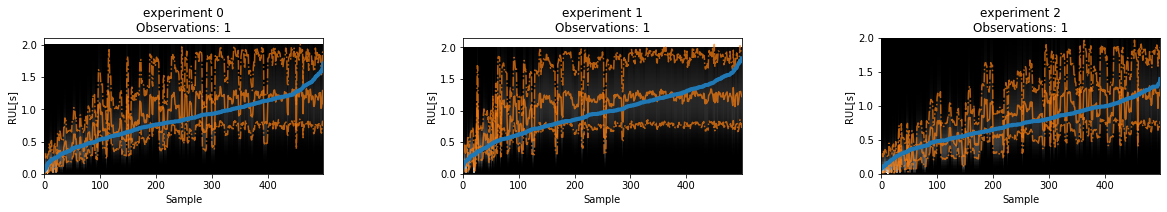

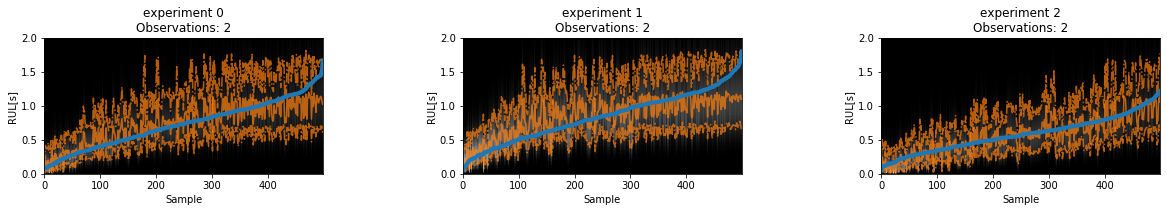

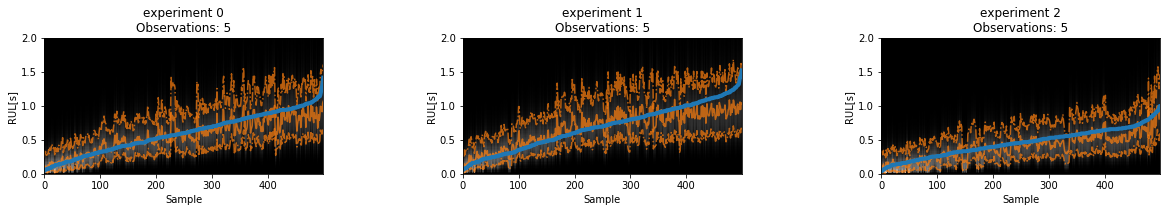

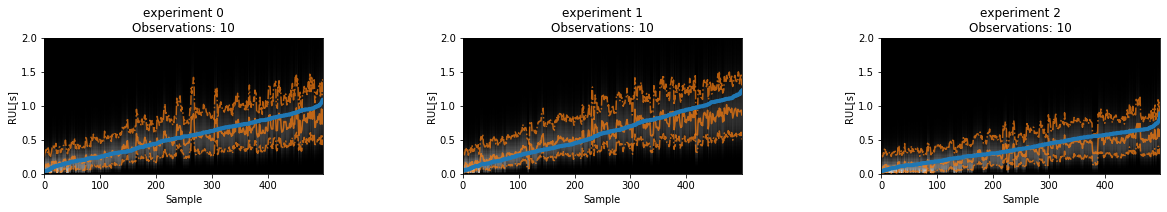

In [42]:
from IPython.display import clear_output
min_spacing = 5;
nseq_range = 100
pplot.figure(figsize = (20,10));
for nnodes in [1,2,5,10]:
#nnodes = 2

    pplot.figure(figsize = (20,10));

    test_data = get_graph_data_multiple_experiments(fic.inds_exp_target,fic.X, eid_oh_ = fic.eid_oh, yrem_norm_ = fic.yrem_norm ,
                                           nsamples_per_experiment = 500, nnodes = nnodes, min_spacing = min_spacing, nseq_range=nseq_range)

    for idx_experiment,data in enumerate(test_data):
        pplot.subplot(3,3,idx_experiment +1, title = "experiment {}\nObservations: {}".format(idx_experiment, nnodes))
        plot_experiment_fit(data, iterations=5, colorscale_fn = lambda x : x,max_time = 2., cmap = "gray")
    pplot.subplots_adjust(wspace=0.5, hspace = 0.5)

In [43]:
#def trim_nodes
g = graph_dat[0].copy()
g.nodes[-1]


NameError: name 'graph_dat' is not defined

In [2]:
import numpy as np
np.random.choice(10,10, replace = False)


array([1, 0, 3, 9, 8, 4, 5, 2, 6, 7])

In [52]:
def get_subgraph_from_nodes(graph, nodes):
    """
    Node should belong to graph. Creates a new graph with coppied edge and 
    node properties, defined from a sub-graph of the original graph.
    parameters:
      graph: the graph we want a sub-graph from 
      nodes: the nodes of the graph we want the subgraph of.
    """
    edges = graph.edges
    sg_nodes_copy = [n.copy() for n in nodes]
    original_copy_nodes_correspondence = {n:nc for n, nc in zip(nodes, sg_nodes_copy)}
    sg_edges_copy = [];
    if len(edges) > 0:
        for e in graph.edges:
            if (e.node_from in nodes) and (e.node_to in nodes):
                sg_edges_copy.append(e.copy(original_copy_nodes_correspondence))
    return Graph(sg_nodes_copy, sg_edges_copy)

#gnew = get_subgraph_from_nodes(graph_dat[0],graph_dat[0].nodes[-1:])
        
#edges_going_to_nodes()
#g.nodes[-1]

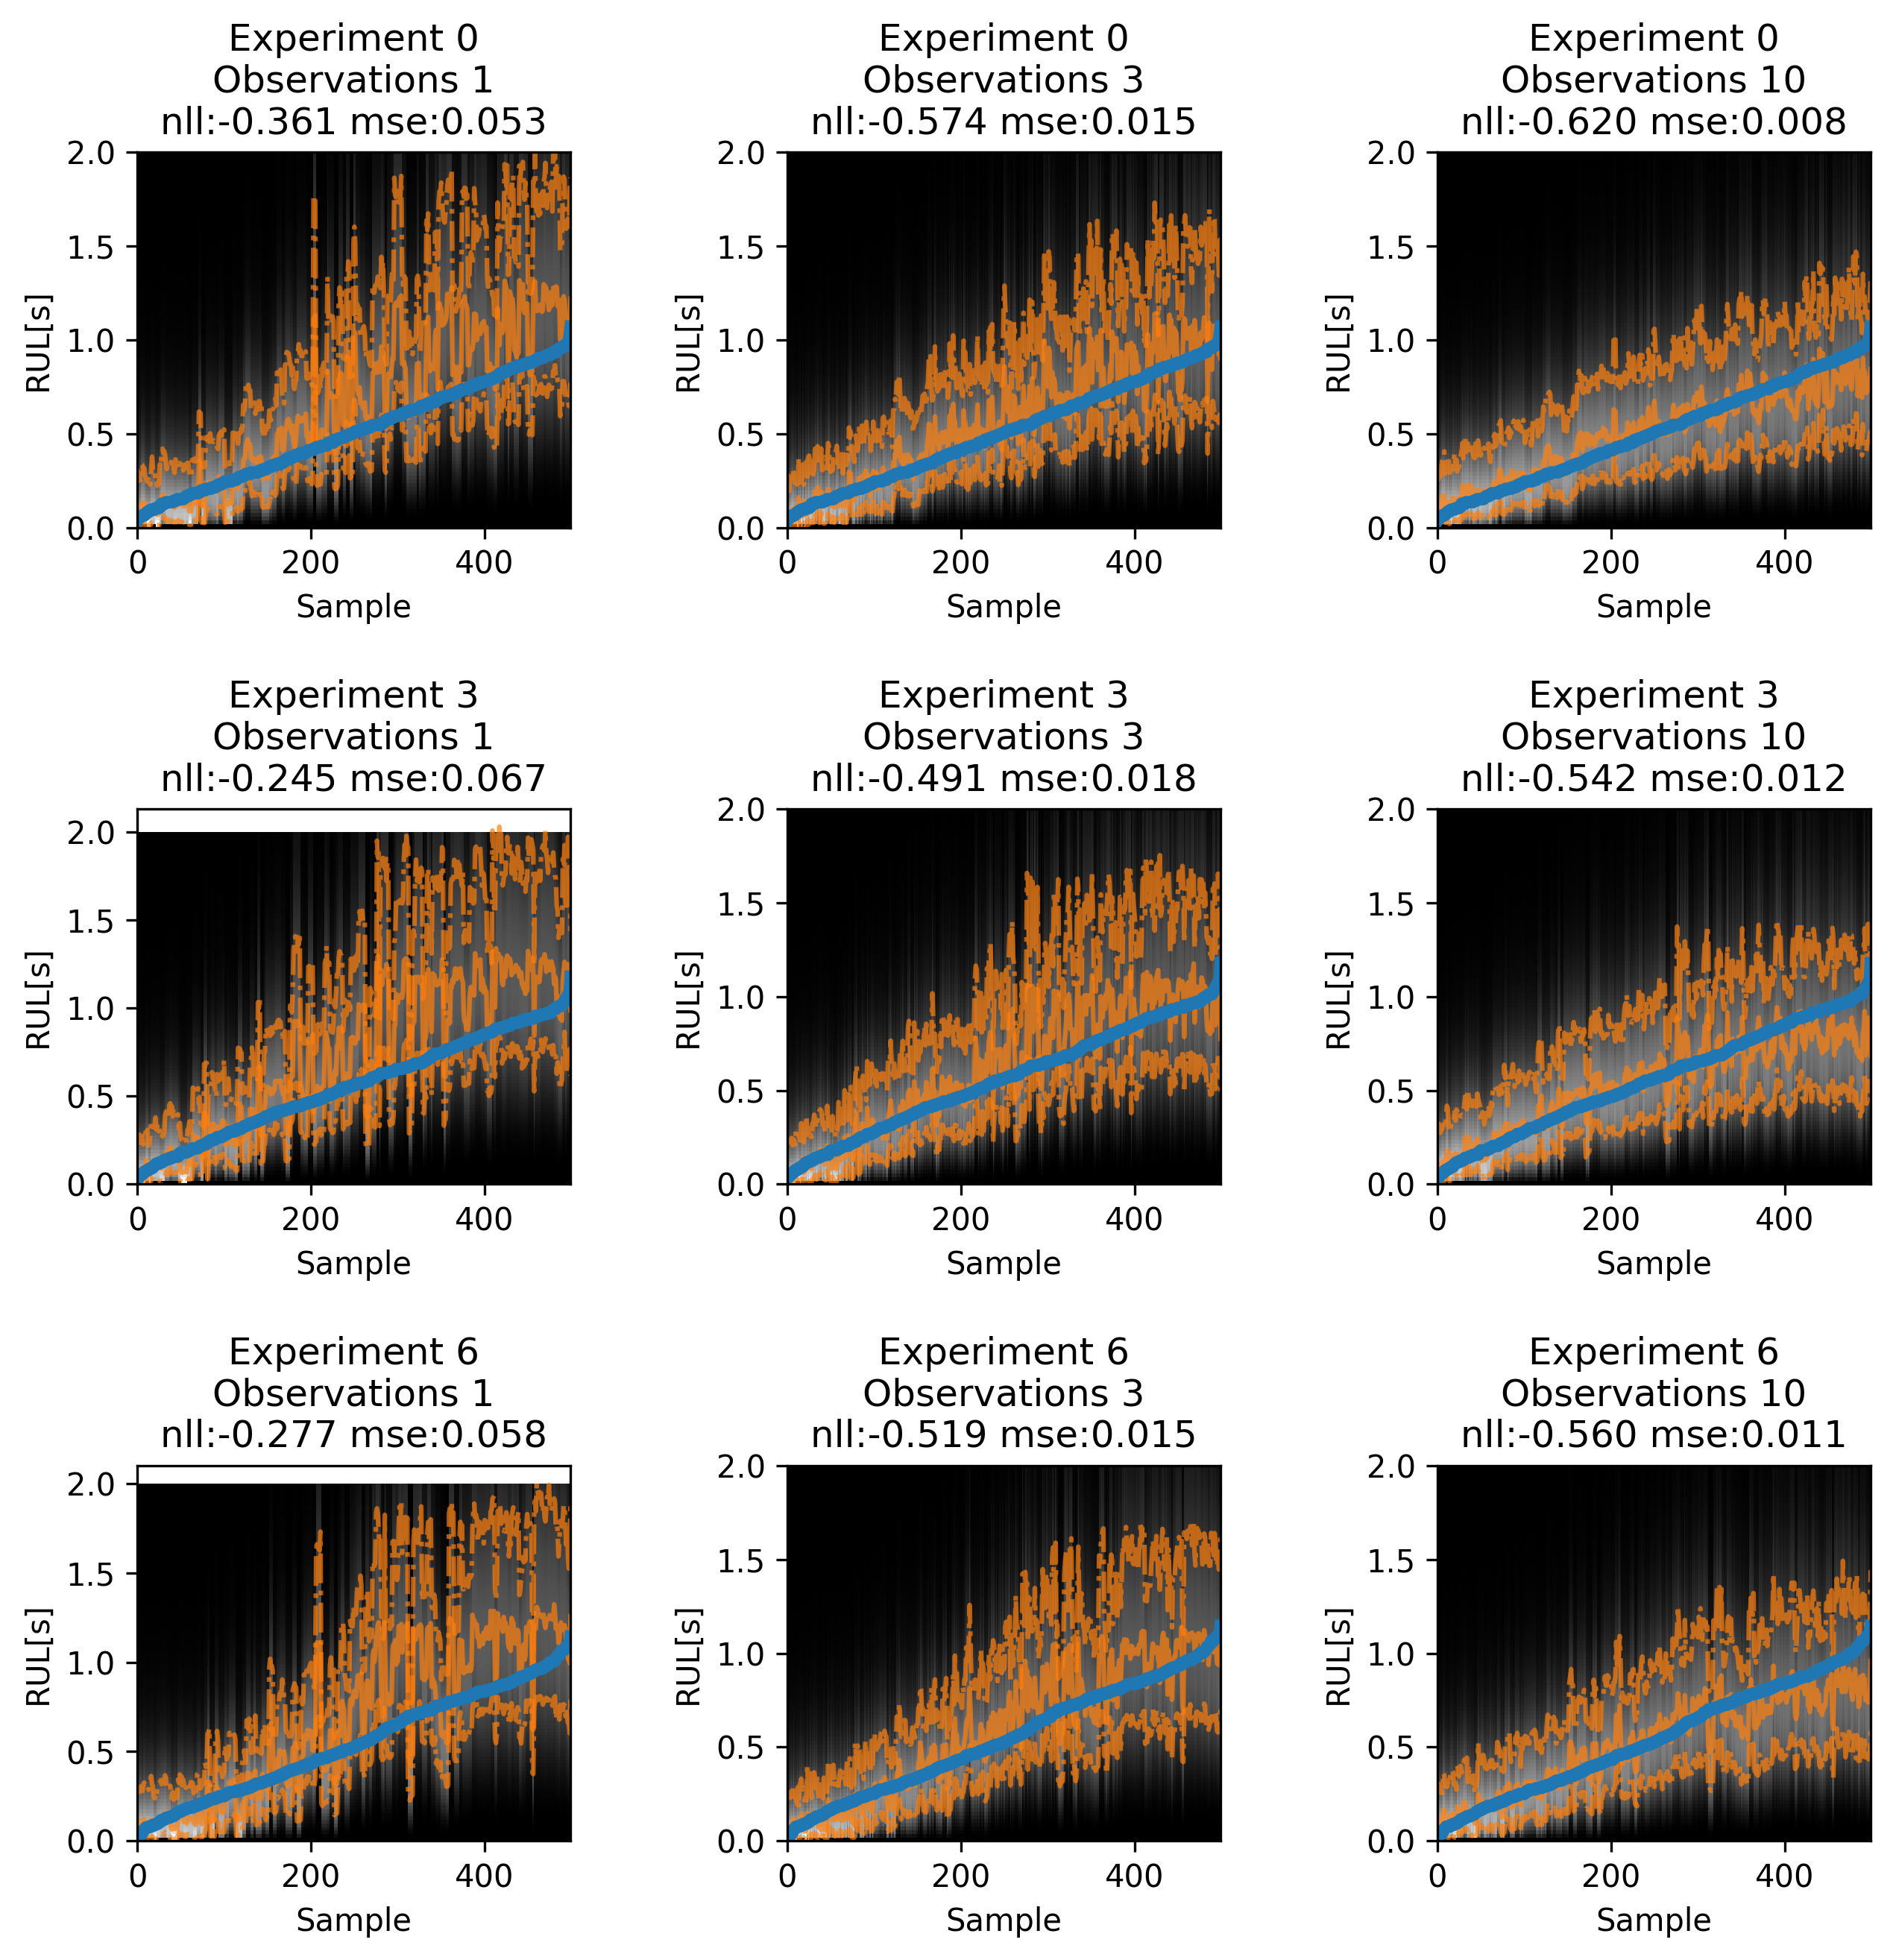

In [70]:
nsampled_graphs = 500;
nnodes_vals = [1, 3,10];
idx_plot = 1
nseq_range = 100
min_spacing = 5
niters = 5



pplot.figure(figsize = (10,10), dpi = 300)
for t in fic.inds_exp_source[0:3]:
    graph_dat10 = get_graph_data( t , X_ = fic.X, eid_oh_ = fic.eid_oh, yrem_norm_=fic.yrem_norm, 
               n_sampled_graphs = nsampled_graphs,nnodes = 10,
               min_spacing = min_spacing, nseq_range = nseq_range)

    for nnodes in nnodes_vals:
        pplot.subplot(len(fic.inds_exp_target), len(nnodes_vals),idx_plot)
        idx_plot += 1
#         graph_dat = get_graph_data( t , X_ = fic.X, eid_oh_ = fic.eid_oh, yrem_norm_=fic.yrem_norm, 
#                        n_sampled_graphs = nsampled_graphs,nnodes = nnodes,
#                        min_spacing = min_spacing, nseq_range = nseq_range)
        graph_input = get_subgraph_from_nodes(graph_dat10[0], graph_dat10[0].nodes[-nnodes:])
        yval = graph_dat10[1]
        ginp = (graph_input, yval)
        res = plot_experiment_fit(ginp, iterations=niters, colorscale_fn = lambda x : x**0.5,max_time = 2., cmap = "gray")
        nll = res[-1]
        mse = np.mean((res[3] - graph_dat10[1])**2)
        title_str = "Experiment {t}\nObservations {nnodes}\nnll:{nll:2.3f} mse:{mse:2.3f}".format(t=t, nnodes=nnodes, nll = nll, mse = mse)
        pplot.title(title_str)

pplot.subplots_adjust(wspace=0.5, hspace = 0.75)

In [65]:
np.mean(np.abs(res[3]- graph_dat10[1])/(graph_dat10[1]))

0.20260455679742118

In [87]:
a = 43
"{a:2.3f}".format(a=3.34122322)

'3.341'

Help on function plot_experiment_fit in module __main__:

plot_experiment_fit(graph_and_result_tuple, iterations=5, max_time=None, colorscale_fn=<function <lambda> at 0x7fa7995dd840>, **kwargs)



In [50]:
help(get_graph_data)

Help on function get_graph_data in module utils:

get_graph_data(experiment, X_=None, eid_oh_=None, yrem_norm_=None, n_sampled_graphs=100, nnodes=3, min_spacing=20, nseq_range=100, fixed_spacing_indices=False, node_time_scaling=5.0)



In [20]:
graph = train_data[0][0]
n = graph.nodes[0]


NameError: name 'train_data' is not defined

In [21]:
pplot.plot(graph.node_times[0])

NameError: name 'graph' is not defined

In [46]:
graphs = gn_tot.eval_graphnets(train_data[2][0].copy())

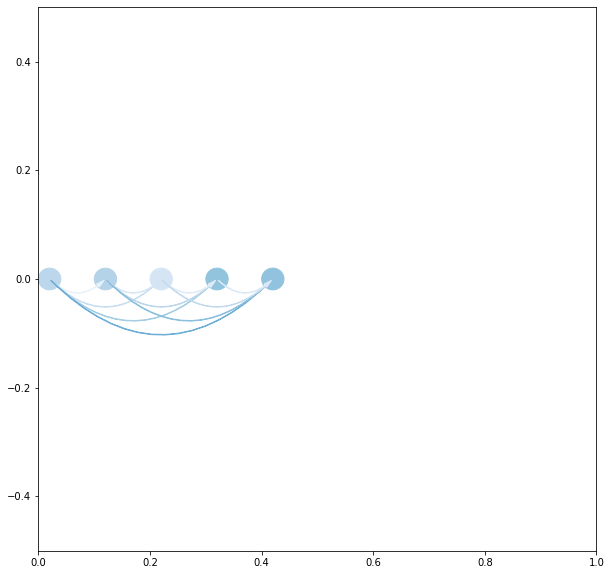

In [41]:
from matplotlib import patches

        
def plot_between_points(from_, to_, **kw_points):
    style = "Simple, tail_width=0.5, head_width=4, head_length=8"
    
    kw_points.update({"arrowstyle" : style})
    a = patches.FancyArrowPatch((from_.center[0],from_.center[1]), (to_.center[0], to_.center[1]),
                                 connectionstyle="arc3,rad=.5", **kw_points)
    
    return a

def graph_patches(g, index_to_plot = 0, derive_node_values = None, xlims = [0,1], sc = 0.1, node_coords = None,node_radious = 0.1,
                  edge_value_to_color = lambda ev : None,
                  node_value_to_color = lambda nc : None, cmap = "copper", node_text = True):
    
    nodes_dict = {n:n.node_attr_tensor[index_to_plot,...] for n in g.nodes}
    edges_dict = {e:e.edge_tensor[index_to_plot,...] for e in g.edges}
    
    edge_cmap  =pplot.get_cmap(cmap)
    node_cmap  =pplot.get_cmap(cmap)
    
    # I use a dictionary so I can resolve connectivity easier.
    #if derive_node_values is None:
    #    node_values = [1.*sc for k in nodes_dict.values()]
    
    node_colors = [] 
    if node_coords is None:
        node_coords_x = [float(k)*0.1-xlims[0]+node_radious for k in range(0, len(nodes_dict))]
        node_coords_y = [0. for kk in node_coords_x];
    
    
    # node patches:
    node_patches = {};
    for n,ncx,ncy in zip(nodes_dict.keys(),node_coords_x, node_coords_y):
        node_color = node_value_to_color(nodes_dict[n])
        node_color_rgb = node_cmap(node_color)
        node_patch_val = {n:patches.Circle((ncx,ncy,0), node_radious, color = node_color_rgb)}
        node_patches.update(node_patch_val)
        
    # edge patches:
    edge_patches = {};
    for ek, ev in zip(edges_dict.keys(), edges_dict.values()):
        
        patch_from = node_patches[ek.node_from]
        patch_to = node_patches[ek.node_to]
        
        edge_color_val = edge_value_to_color(ev)
        if edge_color_val is not None:
            edge_color_val = edge_cmap(edge_color_val)
            
        edge_patches.update({ek : plot_between_points(patch_from, patch_to, color = edge_color_val)})
    
        
    # make node patches:
    return [p_ for p_ in node_patches.values()] , [ep for ep in edge_patches.values()]


p,e = graph_patches(graph,0, sc = 0.03,
                    edge_value_to_color = lambda ev : np.linalg.norm(ev),
                    node_value_to_color = lambda vv : np.max(np.abs(vv)),
                    node_text = [1. for n in graph.nodes],
                    node_radious = 0.02, cmap = "Blues")
fig, ax = pplot.subplots(figsize = (10,10))
ax.set_xlim([0,1])
ax.set_ylim([-0.5,0.5])
for p_ in p:
    ax.add_patch(p_)

for e_ in e:
    ax.add_patch(e_)




In [ ]:
class DraggableGraphNodes(self,node_cirle):
    def __init__(self, node):
        self.node = node
        self.press = None
        
    def connect(self):
        self.cidpress = self.

In [329]:
%matplotlib qt5
import numpy as np
import matplotlib.pyplot as plt

class DraggableRectangle:
    def __init__(self, rect):
        self.rect = rect
        self.press = None

    def connect(self):
        'connect to all the events we need'
#         self.cidpress = self.rect.figure.canvas.mpl_connect(
#             'button_press_event', self.on_press)
#         self.cidrelease = self.rect.figure.canvas.mpl_connect(
#             'button_release_event', self.on_release)
        self.cidpress = self.rect.figure.canvas.mpl_connect(
            'figure_enter_event', self.on_press)
        self.cidrelease = self.rect.figure.canvas.mpl_connect(
            'figure_leave_event', self.on_release)

        self.cidmotion = self.rect.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)

    def on_press(self, event):
        'on button press we will see if the mouse is over us and store some data'
        if event.inaxes != self.rect.axes: return

        contains, attrd = self.rect.contains(event)
        if not contains: return
        print('event contains', self.rect.xy)
        x0, y0 = self.rect.xy
        self.press = x0, y0, event.xdata, event.ydata

    def on_motion(self, event):
        'on motion we will move the rect if the mouse is over us'
        if self.press is None: return
        if event.inaxes != self.rect.axes: return
        x0, y0, xpress, ypress = self.press
        dx = event.xdata - xpress
        dy = event.ydata - ypress
        #print('x0=%f, xpress=%f, event.xdata=%f, dx=%f, x0+dx=%f' %
        #      (x0, xpress, event.xdata, dx, x0+dx))
        self.rect.set_x(x0+dx)
        self.rect.set_y(y0+dy)

        self.rect.figure.canvas.draw()


    def on_release(self, event):
        'on release we reset the press data'
        self.press = None
        self.rect.figure.canvas.draw()

    def disconnect(self):
        'disconnect all the stored connection ids'
        self.rect.figure.canvas.mpl_disconnect(self.cidpress)
        self.rect.figure.canvas.mpl_disconnect(self.cidrelease)
        self.rect.figure.canvas.mpl_disconnect(self.cidmotion)

fig = plt.figure()
ax = fig.add_subplot(111)
rects = ax.bar(range(10), 20*np.random.rand(10))
drs = []
for rect in rects:
    dr = DraggableRectangle(rect)
    dr.connect()
    drs.append(dr)

plt.show()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/core/node_function/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/core/edge_aggregation_function/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/core/edge_function/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/core/node_to_prob/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/graph_independent/node_function/assets
INFO:tensorflow:Assets written to: /tmp/GraphNet_Fictitious/graph_independent/edge_function/assets


In [254]:
p[0].center

(0.0, 0)

In [211]:
help(patches.Polygon)

Help on class Polygon in module matplotlib.patches:

class Polygon(Patch)
 |  A general polygon patch.
 |  
 |  Method resolution order:
 |      Polygon
 |      Patch
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, xy, closed=True, **kwargs)
 |      *xy* is a numpy array with shape Nx2.
 |      
 |      If *closed* is *True*, the polygon will be closed so the
 |      starting and ending points are the same.
 |      
 |      Valid kwargs are:
 |        agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
 |        alpha: float or None
 |        animated: bool
 |        antialiased or aa: unknown
 |        capstyle: {'butt', 'round', 'projecting'}
 |        clip_box: `.Bbox`
 |        clip_on: bool
 |        clip_path: [(`~matplotlib.path.Path`, `.Transform`) | `.Patch` | None]
 |        color: color
 |        contains: callable
 |        edgecolor or ec: color or 

Help on function arrow in module matplotlib.pyplot:

arrow(x, y, dx, dy, **kwargs)
    Add an arrow to the axes.
    
    This draws an arrow from ``(x, y)`` to ``(x+dx, y+dy)``.
    
    Parameters
    ----------
    x, y : float
        The x and y coordinates of the arrow base.
    dx, dy : float
        The length of the arrow along x and y direction.
    
    Returns
    -------
    arrow : `.FancyArrow`
        The created `.FancyArrow` object.
    
    Other Parameters
    ----------------
    **kwargs
        Optional kwargs (inherited from `.FancyArrow` patch) control the
        arrow construction and properties:
    
    Constructor arguments
      *width*: float (default: 0.001)
        width of full arrow tail
    
      *length_includes_head*: bool (default: False)
        True if head is to be counted in calculating the length.
    
      *head_width*: float or None (default: 3*width)
        total width of the full arrow head
    
      *head_length*: float or None (def

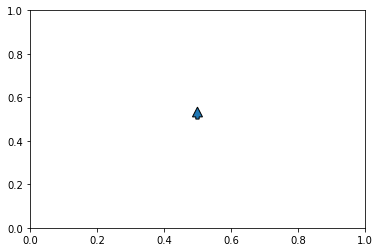

In [233]:
help(pplot.arrow)
pplot.arrow(0.5,0.5,0.0,0.01, width = 0.01,shape= "full")

In [32]:
# a whole experiment:
exp_idx = 2
d = get_dat(all_dat[exp_idx])
y = d['y']
X = d['X'][...,np.newaxis]
n = Node(X)
g = Graph([n],[])
vals = eval_graphnets(g.copy())

## Graph with two observations with a certain time interval between them:
dist_measurements = 20; # distance between measurements
spacing_readings = 1;
y2_0= d['y'][0:-dist_measurements:spacing_readings]
y2_1= d['y'][dist_measurements::spacing_readings]
X0 = d['X'][0:-dist_measurements:spacing_readings][..., np.newaxis]
X1 = d['X'][dist_measurements::spacing_readings][..., np.newaxis]
n0 = Node(X0)
n1 = Node(X1)
e01 = Edge(node_from = n0,node_to = n1, edge_attr_tensor=(y2_1 - y2_0)[:,np.newaxis])
g2 = Graph([n0,n1], [e01])
vals2 = eval_graphnets(g2.copy())


## Graph with three observations with a certain time interval between them:
dist_measurements = 20; # distance between measurements
spacing_readings = 1;
y2_0= d['y'][0:-dist_measurements:spacing_readings]
y2_1= d['y'][dist_measurements::spacing_readings]
X0 = d['X'][0:-dist_measurements:spacing_readings][..., np.newaxis]
X1 = d['X'][dist_measurements::spacing_readings][..., np.newaxis]
n0 = Node(X0)
n1 = Node(X1)
e01 = Edge(node_from = n0,node_to = n1, edge_attr_tensor=(y2_1 - y2_0)[:,np.newaxis])
g2 = Graph([n0,n1], [e01])
vals2 = eval_graphnets(g2.copy())

NameError: name 'all_dat' is not defined

-0.9023638633306188

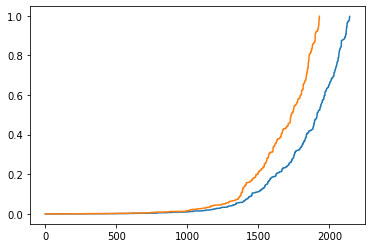

In [255]:
pplot.plot(((latent[0]['latent_values'])/250)**2)
pplot.plot(((latent[2]['latent_values']/250))**2)
np.random.randn()


In [485]:
#graph_indep.graph_eval(g2.copy())
#graph_data_val[0].edges[0].edge_tensor.shape#e01.edge_tensor.shape


In [486]:

X0.shape,X1.shape

((208, 1000, 1), (208, 1000, 1))

AttributeError: 'numpy.ndarray' object has no attribute 'prob'

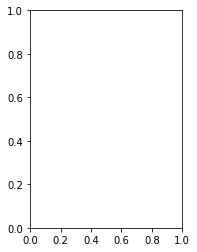

In [38]:
pplot.subplot(1,2,1)
#predictions_val[ids_sort.flatten()]
v = vals.prob(times).numpy().T
pplot.pcolor([r for r in range(v.shape[1])],times*350,v)
# pplot.yscale("log")
# pplot.semilogy(y,"C1")
pplot.plot(y, "C1")

pplot.subplot(1,2,2)
v = vals2.prob(times).numpy().T
pplot.pcolor([r for r in range(v.shape[1])],times*350,v)
#pplot.yscale("log")
#pplot.semilogy(y2_1,"C1")
pplot.plot(y2_1,"C1")


# Done. Success.